In [3]:
import pandas as pd
import matplotlib.pyplot as plt

1. Look at the BAUS zoning for buildings built in PBA50+ DBP

In [25]:
# new buildings output for PBA50+ DBP
bz = pd.read_csv("M:/urban_modeling/baus/PBA50Plus/PBA50Plus_DraftBlueprint/\
PBA50Plus_Draft_Blueprint_v8_znupd_nodevfix/core_summaries/PBA50Plus_Draft_Blueprint_v8_znupd_nodevfix_new_buildings_summary.csv")

2. Add variables to categorize the parcels' "density type" (rural/suburban/urban-suburban/urban) in order to compare againsst their BAUS zoning

In [26]:
# parcels to jurisdiction crosswalk
pg = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/parcels_geography_2024_02_14.csv")
# jurisdiction to "subregion" crosswalk
juris = pd.read_csv("M:/urban_modeling/baus/juris_subregion.csv")

# make the juris column formats match
juris['jurisdiction'] = juris['jurisdiction'].str.lower().str.replace(' ','_').str.replace('.','')
juris.loc[juris.jurisdiction.str.contains("county"), 'jurisdiction'] = 'unincorporated_' + juris['jurisdiction']

# parcel to TAZ crosswalk
ptaz = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/2020_08_17_parcel_to_taz1454sub.csv")
# taz to superdistrict crosswalk
taz = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/taz_geography.csv")
# superdistrict to "subregion" crosswalk
sd = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/superdistricts_geography.csv")

In [27]:
# merge the jurisdiction and superdistrict "subregion" variables
bz = bz.merge(pg[['PARCEL_ID', 'juris']], left_on='parcel_id', right_on='PARCEL_ID', how='left')\
              .merge(juris, left_on='juris', right_on='jurisdiction', how='left')

bz = bz.merge(ptaz[['PARCEL_ID', 'ZONE_ID']], left_on='parcel_id', right_on='PARCEL_ID', how='left')\
              .merge(taz[['zone', 'superdistrict']], left_on='ZONE_ID', right_on='zone', how='left')\
              .merge(sd, left_on='superdistrict', right_on='number')

bz = bz.rename(columns={"subregion_x": "subregion_juris", "subregion_y": "subregion_sd"})

3. Add the base zoning to parcels in order to lookup the corresponding zoning input

In [36]:
# latest parcels zoning file
pz = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/zoning/zoning_parcels_2024-04-30.csv")
# latest parcel lookup file
zl = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/zoning/zoning_lookup_2024-04-30.csv")
zl = zl.rename(columns={"name": "zoning_name"})

# merge the zoning lookup to buildings
bz = bz.merge(pz[['PARCEL_ID', 'zoning_id']], left_on='parcel_id', right_on='PARCEL_ID', how='left')\
.merge(zl[['id', 'zoning_name']], left_on='zoning_id', right_on='id', how='left')

4. Look at the BAUS zoning for parcels as compared to their categorized "density type" and lookup the zoning input for any outliers

BAUS zoning processing:
- Apply BAUS zoning processing from imputation- this infers DUA for far/height and FAR from height, but still picks the min
- eliminates zoning on nodev parcels
- applies rural zoning outside of the urban footprint
- sets max dua to be the highest built density in a TAZ, or if there are no buildings max dua = 4

3a. Look at DUA by "density type"

Rural superdistricts are ['Solano Remainder' 'East Contra Costa' 'SE Snta Clara Cnty'
 'Southern Sonoma' 'Northern Sonoma' 'Napa Remainder' 'Northern Marin']
The correspont to ['vacaville' 'fairfield' 'unincorporated_solano' 'dixon' 'suisun_city'
 'rio_vista' 'brentwood' 'oakley' 'antioch' 'unincorporated_contra_costa'
 'pittsburg' 'concord' 'morgan_hill' 'gilroy' 'unincorporated_santa_clara'
 'san_jose' 'petaluma' 'rohnert_park' 'unincorporated_sonoma' 'sonoma'
 'cotati' 'unincorporated_napa' 'unincorporated_marin' 'healdsburg'
 'windsor' 'cloverdale' 'calistoga' 'napa' 'yountville' 'st_helena'
 'novato']
Their distribution of max DUA is AxesSubplot(0.125,0.125;0.775x0.755)


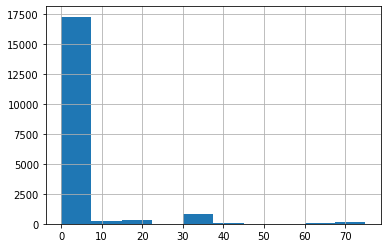

In [74]:
rural = bz.loc[bz.subregion_sd == 4]
print("Rural superdistricts are {}".format(rural.name.unique()))
print("The correspont to {}".format(rural.juris.unique()))
print("Their distribution of max DUA is {}".format(rural.max_dua.hist()))

In [53]:
print("Number of rural parcels with DUA > 60 is {}".format(len(rural.loc[rural.max_dua > 60].parcel_id.unique())))
print("This includes {} zoning codes".format(len(rural.loc[rural.max_dua > 60].zoning_name.unique())))
print("Zoning codes for those parcels are {}".format(rural.loc[rural.max_dua > 60].zoning_name.unique()))

Number of rural parcels with DUA > 60 is 112
This includes 18 zoning codes
Zoning codes for those parcels are ['MU (BASIS)' 'CO (BASIS)' 'P-D (BASIS)' 'OUT (BASIS)' 'RS-5 (BASIS)'
 'C-2 (BASIS)' 'CC (BASIS)' 'LDR (BASIS)' 'B/C (BASIS)' nan 'MM_pba40'
 'M-6 (BASIS)' 'C3 (BASIS)' 'R1 (BASIS)' 'RAL (BASIS)' 'nan (BASIS)'
 'OS (BASIS)' 'RR (BASIS)']


Suburban superdistricts are ['Tri Valley' 'Martinez Concord' 'S Ramon Danville' 'Vallejo Benicia'
 'Santa Rosa Area' 'Lamorinda WC' 'Napa City and S' 'Southern Marin'
 'Central Marin']
The correspond to ['dublin' 'livermore' 'pleasanton' 'unincorporated_alameda' 'concord'
 'unincorporated_contra_costa' 'pleasant_hill' 'pittsburg' 'clayton'
 'martinez' 'lafayette' 'san_ramon' 'danville' 'walnut_creek' 'vallejo'
 'benicia' 'unincorporated_solano' 'sebastopol' 'santa_rosa'
 'unincorporated_sonoma' 'windsor' 'rohnert_park' 'orinda' 'moraga' 'napa'
 'american_canyon' 'unincorporated_napa' 'unincorporated_marin'
 'corte_madera' 'larkspur' 'mill_valley' 'belvedere' 'tiburon' 'sausalito'
 'san_rafael' 'san_anselmo' 'ross' 'fairfax']
Their distribution of max DUA is AxesSubplot(0.125,0.125;0.775x0.755)


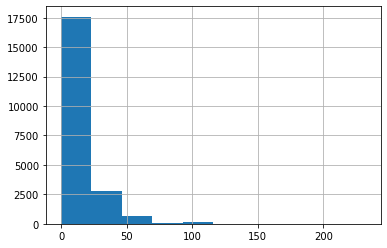

In [75]:
suburban = bz.loc[bz.subregion_sd == 3]
print("Suburban superdistricts are {}".format(suburban.name.unique()))
print("The correspond to {}".format(suburban.juris.unique()))
print("Their distribution of max DUA is {}".format(suburban.max_dua.hist()))

In [61]:
print("Number of suburban parcels with DUA > 100 is {}".format(len(suburban.loc[suburban.max_dua > 100].parcel_id.unique())))
print("This includes {} zoning codes".format(len(suburban.loc[suburban.max_dua > 100].zoning_name.unique())))
print("Zoning codes for those parcels are {}".format(suburban.loc[suburban.max_dua > 100].zoning_name.unique()))

Number of suburban parcels with DUA > 100 is 9
This includes 4 zoning codes
Zoning codes for those parcels are ['RH (HE Data)' '226 - Single Family Low/ Medium Density_pba40'
 'Core Mixed Use (BASIS)' 'Neighborhood Mixed Use (BASIS)']


Suburban-urban superdistricts are ['Richmond Pinole' 'Fremont' 'Palo Alto' 'S Leandro Hayward'
 'Berkeley Eville' 'Redwood City' 'Daly City Millbrae' 'San Mateo']
The correspont to ['richmond' 'unincorporated_contra_costa' 'pinole' 'martinez' 'el_cerrito'
 'san_pablo' 'hercules' 'union_city' 'fremont' 'newark'
 'unincorporated_alameda' 'palo_alto' 'mountain_view' 'los_altos'
 'los_altos_hills' 'unincorporated_santa_clara' 'cupertino' 'sunnyvale'
 'hayward' 'san_leandro' 'oakland' 'berkeley' 'emeryville' 'albany'
 'menlo_park' 'redwood_city' 'san_carlos' 'unincorporated_san_mateo'
 'woodside' 'atherton' 'portola_valley' 'east_palo_alto' 'belmont'
 'millbrae' 'brisbane' 'daly_city' 'san_bruno' 'pacifica'
 'south_san_francisco' 'burlingame' 'colma' 'san_francisco' 'san_mateo'
 'half_moon_bay' 'foster_city' 'hillsborough']
Their distribution of max DUA is AxesSubplot(0.125,0.125;0.775x0.755)


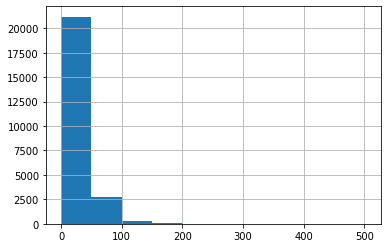

In [77]:
suburbanurban = bz.loc[bz.subregion_sd == 2]
print("Suburban-urban superdistricts are {}".format(suburbanurban.name.unique()))
print("The correspont to {}".format(suburbanurban.juris.unique()))
print("Their distribution of max DUA is {}".format(suburbanurban.max_dua.hist()))

In [64]:
print("Number of Suburban-urban parcels with DUA > 100 is {}".format(len(suburbanurban.loc[suburbanurban.max_dua > 100].parcel_id.unique())))
print("This includes {} zoning codes".format(len(suburbanurban.loc[suburbanurban.max_dua > 100].zoning_name.unique())))
print("Zoning codes for those parcels are {}".format(suburbanurban.loc[suburbanurban.max_dua > 100].zoning_name.unique()))

Number of Suburban-urban parcels with DUA > 100 is 274
This includes 71 zoning codes
Zoning codes for those parcels are ['CM-5 (BASIS)' 'CM5 (HE Data)' 'RC (HE Data)' 'CSMU (BASIS)'
 'P(38) - El Camino Real Precise Plan (HE Data)' 'R1 (BASIS)'
 'RHS (BASIS)' 'MUTOD (BASIS)' 'DA-1 (BASIS)' 'DA-2 (BASIS)'
 'DA-4 (BASIS)' '112 - General Commercial_pba40' 'DT-MS (HE Data)'
 'UC (HE Data)' 'C-DMU Buffer_pba40' 'C-W (HE Data)'
 'Mixed Use with Residential (MUR) (HE Data)' 'RHD-4-135-55_pba40'
 'C-DMU Buffer (HE Data)' 'C-DMU Core_pba40' 'R-2A_pba40'
 'C-DMU Corridor_pba40' 'C-1_pba40' 'C-T (HE Data)' 'MUR (BASIS)'
 'C-W_pba40' 'Community Commercial_pba40' 'C-DMU Outer Core (HE Data)'
 'C-U (HE Data)' 'C-DMU Core (HE Data)' 'R-4 (HE Data)'
 'C-DMU Corridor (HE Data)' 'RH (BASIS)' 'C-AC (HE Data)'
 'MUR-4-135-100_pba40' 'R-SMU (HE Data)' 'MU-D-120 (HE Data)' 'CBR_pba40'
 'M-1_pba40' 'MU-DC_pba40' 'MU-SB_pba40' 'MU-N-120 (HE Data)' 'R-5_pba40'
 'MSASPD-TOD (BASIS)' 'RRMU (BASIS)' 'MSASP General

Urban jurisdictions are ['oakland' 'alameda' 'piedmont' 'emeryville' 'unincorporated_alameda'
 'san_leandro' 'san_jose' 'unincorporated_santa_clara' 'santa_clara'
 'campbell' 'los_gatos' 'cupertino' 'saratoga' 'monte_sereno' 'los_altos'
 'san_francisco' 'daly_city' 'mountain_view' 'sunnyvale' 'milpitas'
 'palo_alto']
Their distribution of max DUA is AxesSubplot(0.125,0.125;0.775x0.755)


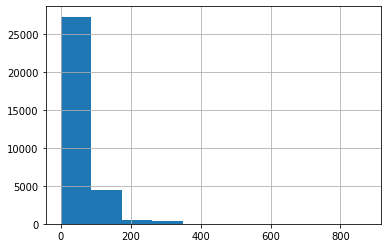

In [65]:
urban = bz.loc[bz.subregion_sd == 1]
print("Urban jurisdictions are {}".format(urban.juris.unique()))
print("Their distribution of max DUA is {}".format(urban.max_dua.hist()))

In [66]:
print("Number of Urban parcels with DUA > 200 is {}".format(len(urban.loc[urban.max_dua > 200].parcel_id.unique())))
print("This includes {} zoning codes".format(len(urban.loc[urban.max_dua > 200].zoning_name.unique())))
print("Zoning codes for those parcels are {}".format(urban.loc[urban.max_dua > 200].zoning_name.unique()))

Number of Urban parcels with DUA > 200 is 684
This includes 45 zoning codes
Zoning codes for those parcels are ['Institutional_pba40' 'CBD-C (HE Data)' 'D-LM-4 (HE Data)'
 'Central Business District_pba40' 'Downtown_pba40' 'DC (HE Data)'
 'UV (BASIS)' 'DC-NT1 (HE Data)' 'Transit Residential_pba40'
 'Combined Industrial/Commercial_pba40' 'UV (HE Data)'
 'C-3-O(SD) (HE Data)' 'C-3-G (HE Data)' 'C-3-O (HE Data)' 'MUR (HE Data)'
 'CMUO (HE Data)' 'C-3-R (HE Data)' 'C-3-S (HE Data)' 'MUO (HE Data)'
 'NCT-FOLSOM (HE Data)' 'DOWNTOWN- OFFICE-300-S_pba40' 'CRNC (HE Data)'
 'MUG (HE Data)' 'RC-4 (HE Data)' 'NCT-SOMA (HE Data)' 'RM-4 (HE Data)'
 'UMU (HE Data)' 'RM-4 (BASIS)' 'P (HE Data)' 'RH DTR (HE Data)'
 'WMUG (HE Data)' 'NEIGHBORHOOD COMMERCIAL, MODERATE SCALE-130-V_pba40'
 'NCT-3 (HE Data)' "240' Height Allowed (HE Data)"
 "85' Height Allowed (HE Data)" 'NCT-DIVISADERO (HE Data)'
 'NCT-FILLMORE (HE Data)' 'NCT-UPPER MARKET (HE Data)'
 'NCT-HAYES (HE Data)' 'RTO (HE Data)' 'NCT-MISSION (HE

3b. Look at FAR by "density type"

Rural distribution of max FAR is AxesSubplot(0.125,0.125;0.775x0.755)


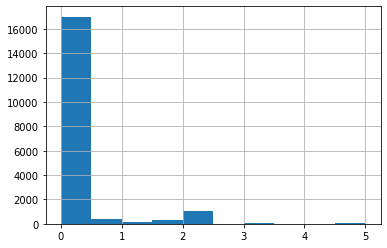

In [70]:
print("Rural distribution of max FAR is {}".format(rural.max_far.hist()))

In [73]:
print("Number of rural parcels with FAR > 3 is {}".format(len(rural.loc[rural.max_far > 3].parcel_id.unique())))
print("This includes {} zoning codes".format(len(rural.loc[rural.max_far > 3].zoning_name.unique())))
print("Zoning codes for those parcels are {}".format(rural.loc[rural.max_far > 3].zoning_name.unique()))

Number of rural parcels with FAR > 3 is 22
This includes 13 zoning codes
Zoning codes for those parcels are ['C-S (BASIS)' 'P-D (BASIS)' 'RS-5 (BASIS)' 'CC (BASIS)' 'LDR (BASIS)'
 'C-2 (BASIS)' nan 'C3 (BASIS)' 'MU (BASIS)' 'R1 (BASIS)' 'RAL (BASIS)'
 'nan (BASIS)' 'OS (BASIS)']


Suburban distribution of max FAR is AxesSubplot(0.125,0.125;0.775x0.755)


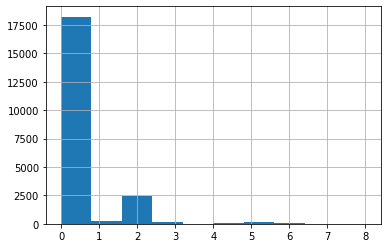

In [84]:
print("Suburban distribution of max FAR is {}".format(suburban.max_far.hist()))

In [86]:
print("Number of suburban parcels with FAR > 3 is {}".format(len(suburban.loc[suburban.max_far > 3].parcel_id.unique())))
print("This includes {} zoning codes".format(len(suburban.loc[suburban.max_far > 3].zoning_name.unique())))
print("Zoning codes for those parcels are {}".format(suburban.loc[suburban.max_far > 3].zoning_name.unique()))

Number of suburban parcels with FAR > 3 is 216
This includes 46 zoning codes
Zoning codes for those parcels are ['C-R (m)/PUD-MU (HE Data)' 'DDTOD (BASIS)' 'C (BASIS)' 'DD-ZD (BASIS)'
 'P/HS (BASIS)' 'DDVPD (BASIS)' 'RC (BASIS)' 'WMX (BASIS)' 'DP (BASIS)'
 'HDR_pba40' 'M-3 (BASIS)' 'DTMU_pba40' 'RB (BASIS)' 'PUD (BASIS)'
 'OF (BASIS)' 'MH_pba40' 'OA-H (BASIS)' 'RHD (BASIS)'
 'Core Mixed Use (BASIS)' 'Neighborhood Mixed Use (BASIS)' 'DTC (BASIS)'
 'MFMH_pba40' 'P-D (HE Data)' 'MU-C (HE Data)' 'O-C (BASIS)' 'MFVH_pba40'
 'P-R (BASIS)' 'WEC (BASIS)' 'MU-PD (BASIS)' 'MR-A (BASIS)'
 'MU-PD (HE Data)' 'P-D (BASIS)' 'Downtown Commercial (DC) (HE Data)'
 'C-F (BASIS)' 'MFSH_pba40' 'C-C (BASIS)' 'AS (BASIS)' 'DC (BASIS)'
 'RL-6 (BASIS)' 'O (BASIS)' 'T5N 50/70 (HE Data)' 'T4N 40/50 (HE Data)'
 'T5MS 70/90 (HE Data)' 'T4MS 40/60 (HE Data)' 'T4MS 50/70 (HE Data)'
 'T4MS 60/80 (HE Data)']


Suburban-urban distribution of max FAR is AxesSubplot(0.125,0.125;0.775x0.755)


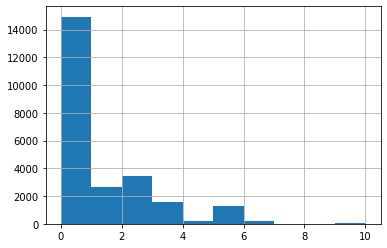

In [78]:
print("Suburban-urban distribution of max FAR is {}".format(suburbanurban.max_far.hist()))

In [88]:
print("Number of suburban-urban parcels with FAR > 6 is {}".format(len(suburbanurban.loc[suburbanurban.max_far > 6].parcel_id.unique())))
print("This includes {} zoning codes".format(len(suburbanurban.loc[suburbanurban.max_far > 6].zoning_name.unique())))
print("Zoning codes for those parcels are {}".format(suburbanurban.loc[suburbanurban.max_far > 6].zoning_name.unique()))

Number of suburban-urban parcels with FAR > 6 is 176
This includes 26 zoning codes
Zoning codes for those parcels are ['RH (BASIS)' 'MUTOD (BASIS)' 'DA-1 (BASIS)' 'DA-4 (BASIS)'
 '112 - General Commercial_pba40' 'DA-2 (BASIS)' 'RU-4 (BASIS)'
 'MSASPD-TOD (BASIS)' 'RRMU (BASIS)' 'MSASP General Commercial-30_pba40'
 'MSASPD-EIZ (BASIS)' 'NBMU (BASIS)' 'R-3 (BASIS)'
 'Park and Open Space_pba40' 'MSASP Quasi-Public_pba40'
 '606 - Retail and Office_pba40' 'DIA (BASIS)'
 'MSASP Quasi-Public-30_pba40' 'C-MU (BASIS)'
 '606 - Low Density Residential_pba40'
 '606 - Medium-Low Density Residential_pba40' 'C (BASIS)'
 '606 - Government Facilities_pba40' nan 'C-RO (BASIS)' 'R-MD (BASIS)']


Urban distribution of max FAR is AxesSubplot(0.125,0.125;0.775x0.755)


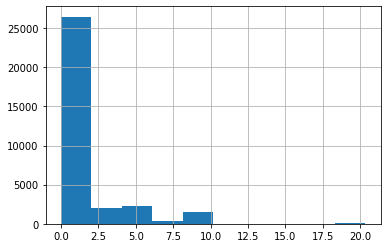

In [81]:
print("Urban distribution of max FAR is {}".format(urban.max_far.hist()))

In [83]:
print("Number of Urban parcels with FAR > 10 is {}".format(len(urban.loc[urban.max_far > 10].parcel_id.unique())))
print("This includes {} zoning codes".format(len(urban.loc[urban.max_far > 10].zoning_name.unique())))
print("Zoning codes for those parcels are {}".format(urban.loc[urban.max_far > 10].zoning_name.unique()))

Number of Urban parcels with FAR > 10 is 47
This includes 9 zoning codes
Zoning codes for those parcels are ['D-LM-4 (BASIS)' 'S-15 (BASIS)' 'Central Business District_pba40'
 'S-15W (BASIS)' 'Downtown_pba40' 'Transit Residential_pba40'
 'Combined Industrial/Commercial_pba40' 'DOWNTOWN- OFFICE-300-S_pba40'
 "240' Height Allowed (HE Data)"]
